https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import torch
import torch.nn as nn

path = Path.home() / '.data' / 'asl-signs'

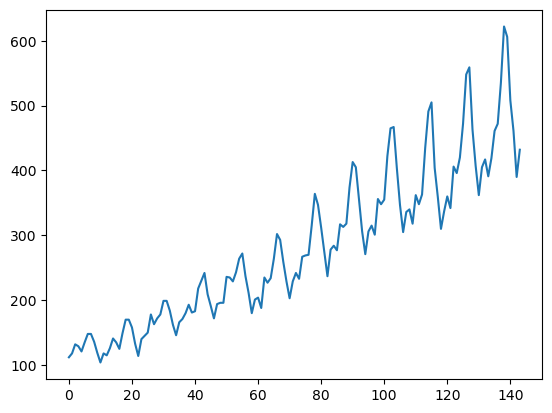

In [14]:
df = pd.read_csv(path / 'airline-passengers.csv')

plt.plot(df.Passengers)
plt.show()

In [109]:
df.iloc[95:]

,Month,Passengers
95,1956-12,306
96,1957-01,315
97,1957-02,301
98,1957-03,356
99,1957-04,348
100,1957-05,355
101,1957-06,422
102,1957-07,465
103,1957-08,467
104,1957-09,404


In [15]:
# train-test split for time series
timeseries = df[["Passengers"]].values.astype('float32')

train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

In [94]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+lookback]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [112]:
X_train[0]

tensor([[112.],
        [118.],
        [132.],
        [129.]])

In [100]:
len(X_test)

44

In [103]:
y_train[-1]

tensor([306.])

In [111]:
y_test[0]

tensor([355.])

In [95]:
lookback = 4
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([92, 4, 1]) torch.Size([92, 1])
torch.Size([44, 4, 1]) torch.Size([44, 1])


In [96]:
class AirModel(nn.Module):
    def __init__(self, hidden_size=50):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_size, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.linear(x)
        return x

In [97]:
y_pred.shape, y_train[:, :, 0].shape

IndexError: too many indices for tensor of dimension 2

In [98]:
import numpy as np
import torch.optim as optim
import torch.utils.data as data
 
model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)
 
n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 228.9180, test RMSE 428.1105
Epoch 100: train RMSE 176.0643, test RMSE 372.6861
Epoch 200: train RMSE 136.4756, test RMSE 329.2901
Epoch 300: train RMSE 104.9563, test RMSE 291.4128
Epoch 400: train RMSE 79.0787, test RMSE 256.0744
Epoch 500: train RMSE 59.4103, test RMSE 224.2945
Epoch 600: train RMSE 45.9864, test RMSE 197.8049
Epoch 700: train RMSE 36.6442, test RMSE 174.4069
Epoch 800: train RMSE 31.0844, test RMSE 163.1933
Epoch 900: train RMSE 27.7511, test RMSE 148.0007
Epoch 1000: train RMSE 25.7235, test RMSE 138.5413
Epoch 1100: train RMSE 24.6801, test RMSE 129.2344
Epoch 1200: train RMSE 23.7596, test RMSE 118.9635
Epoch 1300: train RMSE 22.5800, test RMSE 113.6776
Epoch 1400: train RMSE 21.4155, test RMSE 112.8739
Epoch 1500: train RMSE 20.7250, test RMSE 109.1236
Epoch 1600: train RMSE 20.3569, test RMSE 108.0226
Epoch 1700: train RMSE 19.7202, test RMSE 102.7803
Epoch 1800: train RMSE 19.3919, test RMSE 101.7576
Epoch 1900: train RMSE 18.9400, test RM

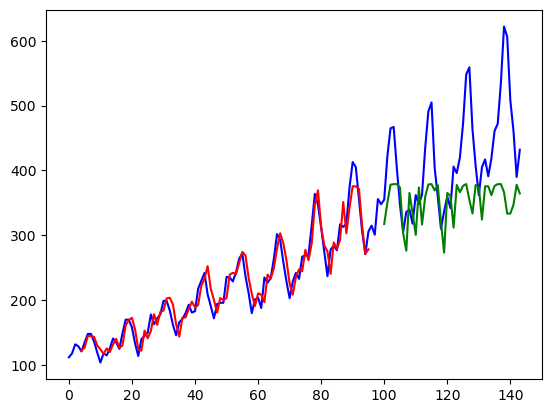

In [99]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred
    train_plot[lookback:train_size] = model(X_train)
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)
# plot
plt.plot(timeseries, c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()